In [4]:
import pandas as pd
import numpy as np

# 1. Cargar el archivo de promedios
file_path = "exportados/Robos a casa habitacion/cuadrantes_robos_CaHa_promedio.xlsx"
df_promedios = pd.read_excel(file_path)

# Renombrar columnas para facilitar el manejo
column_names = {
    'CUADRANTE': 'CUADRANTE',
    'POBLACION': 'POBLACION'
}
for i in range(1, 13):
    column_names[f'PROMEDIO DE ROBOS A CASA HABITACION MES {i}'] = f'ROBOS_MES_{i}'

df_promedios.rename(columns=column_names, inplace=True)

# 2. Desapilar (Unpivot) la tabla para crear las 936 filas
# La columna 'POBLACION' se mantiene fija para cada cuadrante.
df_long = df_promedios.melt(
    id_vars=['CUADRANTE', 'POBLACION'],
    value_vars=[f'ROBOS_MES_{i}' for i in range(1, 13)],
    var_name='MES_NOMBRE',
    value_name='ROBOS_MES_N' # Este es el valor que queremos predecir (Y)
)

# 3. Extraer el número de mes (MES_N)
df_long['MES_N'] = df_long['MES_NOMBRE'].str.extract(r'(\d+)').astype(int)
df_long.drop(columns=['MES_NOMBRE'], inplace=True)

# 4. Ordenar la tabla por CUADRANTE y MES_N
df_long.sort_values(by=['MES_N', 'CUADRANTE'], inplace=True)
df_long.reset_index(drop=True, inplace=True)

print("### 1. DataFrame de 936 Filas (Formato de Serie de Tiempo) ###")
print(df_long.head(80).tail(5)) # Muestra los últimos del Mes 1
print(f"\nTotal de filas: {len(df_long)}")
print("-" * 50)

### 1. DataFrame de 936 Filas (Formato de Serie de Tiempo) ###
    CUADRANTE  POBLACION  ROBOS_MES_N  MES_N
75         76      15331     0.909091      1
76         77      13950     1.727273      1
77         78      12572     0.909091      1
78          1          0     0.090909      2
79          2          0     0.000000      2

Total de filas: 936
--------------------------------------------------


In [5]:
# 5. Crear la columna de Diciembre (MES 12) para usarla como N-1 del Mes 1
# Extraer los promedios de Diciembre (MES 12)
df_diciembre = df_long[df_long['MES_N'] == 12].copy()
df_diciembre.rename(columns={'ROBOS_MES_N': 'ROBOS_DIC'}, inplace=True)
df_diciembre = df_diciembre[['CUADRANTE', 'ROBOS_DIC']]

# Extraer los promedios de Noviembre (MES 11)
df_noviembre = df_long[df_long['MES_N'] == 11].copy()
df_noviembre.rename(columns={'ROBOS_MES_N': 'ROBOS_NOV'}, inplace=True)
df_noviembre = df_noviembre[['CUADRANTE', 'ROBOS_NOV']]

# 6. Crear las columnas N-1 y N-2 usando 'shift' agrupado
df_long['ROBOS_MES_N_MENOS_1'] = df_long.groupby('CUADRANTE')['ROBOS_MES_N'].shift(1)
df_long['ROBOS_MES_N_MENOS_2'] = df_long.groupby('CUADRANTE')['ROBOS_MES_N'].shift(2)

# 7. Imputar Enero (MES_N = 1 y 2) con los valores de Diciembre y Noviembre
# El Mes 1 (Enero) toma N-1 de Diciembre y N-2 de Noviembre.
df_long = df_long.merge(df_diciembre, on='CUADRANTE', how='left')
df_long.loc[df_long['MES_N'] == 1, 'ROBOS_MES_N_MENOS_1'] = df_long.loc[df_long['MES_N'] == 1, 'ROBOS_DIC']

df_long = df_long.merge(df_noviembre, on='CUADRANTE', how='left')
df_long.loc[df_long['MES_N'] == 1, 'ROBOS_MES_N_MENOS_2'] = df_long.loc[df_long['MES_N'] == 1, 'ROBOS_NOV']

# El Mes 2 (Febrero) toma N-2 de Diciembre
df_long.loc[df_long['MES_N'] == 2, 'ROBOS_MES_N_MENOS_2'] = df_long.loc[df_long['MES_N'] == 2, 'ROBOS_DIC']

df_final = df_long.drop(columns=['ROBOS_DIC', 'ROBOS_NOV'])

print("### 2. DataFrame Final con Variables N-1 y N-2 (Primeros 5 cuadrantes) ###")
print(df_final.head(5))
print("-" * 50)

### 2. DataFrame Final con Variables N-1 y N-2 (Primeros 5 cuadrantes) ###
   CUADRANTE  POBLACION  ROBOS_MES_N  MES_N  ROBOS_MES_N_MENOS_1  \
0          1          0     0.636364      1             0.181818   
1          2          0     0.090909      1             0.000000   
2          3      18838     5.454545      1             2.181818   
3          4      20919     1.363636      1             1.727273   
4          5        391     0.181818      1             0.000000   

   ROBOS_MES_N_MENOS_2  
0             0.363636  
1             0.000000  
2             1.636364  
3             2.181818  
4             0.090909  
--------------------------------------------------


In [ ]:
# exportar el DataFrame final df.final a un archivo Excel
#output_file_path = "exportados/Robos a casa habitacion/serie_tiempo_robos_casa_habitacion.xlsx"
#df_final.to_excel(output_file_path, index=False)
#print(f"DataFrame final exportado a: {output_file_path}")

DataFrame final exportado a: exportados/Robos a casa habitacion/serie_tiempo_robos_casa_habitacion.xlsx


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler # <-- para normalizar

# 1. Separar la tabla para aplicar el escalador
df_scale = df_final[['CUADRANTE', 'POBLACION', 'ROBOS_MES_N_MENOS_1', 'ROBOS_MES_N_MENOS_2', 'ROBOS_MES_N']].copy()

# 2. Aplicar el escalador (entrenado SOLO con los datos de entrada X)
# El escalador debe tratar todas las variables por separado
scaler = MinMaxScaler()
df_scaled_values = scaler.fit_transform(df_scale)
df_scaled = pd.DataFrame(df_scaled_values, columns=df_scale.columns)
df_scaled['MES_N'] = df_final['MES_N'].values # Añadir el MES_N de vuelta

# 3. Estructurar X y Y para Keras (Múltiples Salidas) con datos escalados
X_features_scaled = df_scaled[['CUADRANTE', 'POBLACION', 'ROBOS_MES_N_MENOS_1', 'ROBOS_MES_N_MENOS_2']]
Y_output_scaled = df_scaled['ROBOS_MES_N']

# Agrupar los datos escalados
X_data_scaled = X_features_scaled.groupby(df_scaled['MES_N']).apply(lambda x: x.values.flatten()).tolist()
Y_data_scaled = Y_output_scaled.groupby(df_scaled['MES_N']).apply(lambda x: x.values).tolist()

X_scaled = np.array(X_data_scaled)
Y_scaled = np.array(Y_data_scaled)

# Dividir para entrenamiento y prueba (mantenemos test_size=0.15 por ahora)
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(
    X_scaled, Y_scaled, test_size=0.15, shuffle=False
)

input_dim = X_scaled.shape[1]
output_dim = Y_scaled.shape[1]

# 4. Reconstruir y Entrenar el Modelo Keras (con datos escalados)
# Se reduce la tasa de aprendizaje (learning rate) como medida de precaución adicional
model_scaled = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(output_dim, activation='linear')
])

model_scaled.compile(optimizer=Adam(learning_rate=0.0005), loss='mse') # Reducción de LR
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("### Entrenamiento del Modelo Keras (Datos Normalizados) ###")
model_scaled.fit(
    X_train_scaled, Y_train_scaled,
    epochs=200, # Aumentamos épocas por si acaso
    batch_size=2,
    validation_data=(X_test_scaled, Y_test_scaled),
    callbacks=[early_stop],
    verbose=0
)
print("Entrenamiento con normalización finalizado.")

# 5. Evaluación (R^2)
Y_pred_test_scaled = model_scaled.predict(X_test_scaled)
r2_scaled = r2_score(Y_test_scaled.flatten(), Y_pred_test_scaled.flatten())

print(f"\n### Coeficiente de Determinación (R^2) con Normalización: {r2_scaled:.4f} ###")

2025-11-13 20:49:22.464700: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 20:49:22.513487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 20:49:25.137751: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-13 20:49:26.239614: E external/local_xl

### Entrenamiento del Modelo Keras (Datos Normalizados) ###
Entrenamiento con normalización finalizado.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

### Coeficiente de Determinación (R^2) con Normalización: 0.7755 ###


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error


def predecir_y_evaluar_top_cuadrantes(mes_a_predecir, df_historico, modelo, escalador, df_datos_reales):
    """
    Predice y evalúa el robo promedio a negocios para los 78 cuadrantes en un mes N.

    Args:
        mes_a_predecir (int): El número del mes que se quiere predecir (ej. 13).
        df_historico (pd.DataFrame): El DataFrame con los promedios históricos (df_final).
        modelo (tf.keras.Model): El modelo de Keras entrenado (model_scaled).
        escalador (sklearn.preprocessing.MinMaxScaler): El objeto MinMaxScaler.
        df_datos_reales (pd.DataFrame): DataFrame con la columna 'ROBOS_MES_N' real para ese mes N.

    Returns:
        tuple: (DataFrame del Top 10, R2, MAE)
    """

    print(f"--- Ejecutando Predicción y Evaluación para el Mes {mes_a_predecir} ---")

    # 1. Definir meses históricos cíclicos
    mes_n_menos_1 = (mes_a_predecir - 1)
    mes_n_menos_2 = (mes_a_predecir - 2)
    mes_anterior_ciclo = (mes_n_menos_1 - 1) % 12 + 1
    mes_anterior_2_ciclo = (mes_n_menos_2 - 1) % 12 + 1

    # 2. Obtener los 78 datos de entrada de los meses N-1 y N-2
    df_n_menos_1 = df_historico[df_historico['MES_N'] == mes_anterior_ciclo].copy()
    df_n_menos_2 = df_historico[df_historico['MES_N'] == mes_anterior_2_ciclo].copy()

    # 3. Construir el DataFrame de Entrada (78 filas)
    df_prediccion = df_historico[df_historico['MES_N'] == 1].copy()

    # Asegurar orden y rellenar las columnas de entrada
    df_prediccion.sort_values(by='CUADRANTE', inplace=True)
    df_n_menos_1.sort_values(by='CUADRANTE', inplace=True)
    df_n_menos_2.sort_values(by='CUADRANTE', inplace=True)

    df_prediccion['ROBOS_MES_N_MENOS_1'] = df_n_menos_1['ROBOS_MES_N'].values
    df_prediccion['ROBOS_MES_N_MENOS_2'] = df_n_menos_2['ROBOS_MES_N'].values

    # 4. Preparar, Escalar y Aplanar la matriz X (312 entradas)
    X_pred_raw = df_prediccion[['CUADRANTE', 'POBLACION', 'ROBOS_MES_N_MENOS_1', 'ROBOS_MES_N_MENOS_2']].values
    X_con_dummy = np.hstack((X_pred_raw, np.zeros((X_pred_raw.shape[0], 1))))
    X_pred_escalado_completo = escalador.transform(X_con_dummy)
    X_pred_final = X_pred_escalado_completo[:, :4].flatten().reshape(1, -1)

    # 5. Realizar la Predicción (Y_pred_scaled)
    Y_pred_scaled = modelo.predict(X_pred_final)

    # 6. Desescalar la Predicción (Y_pred_desescalado)
    Y_pred_full = np.hstack((X_pred_raw, Y_pred_scaled.T))
    Y_pred_desescalado = escalador.inverse_transform(Y_pred_full)[:, -1]

    # 7. Generar el Top N (DataFrame de resultados)
    df_resultado = pd.DataFrame({
        'CUADRANTE': df_prediccion['CUADRANTE'].values,
        'PREDICCION_ROBOS_MES_N': Y_pred_desescalado,
        'MES_PREDICHO': mes_a_predecir
    })

    # 8. EVALUACIÓN Y COMPARACIÓN con Datos Reales
    # Aseguramos que el orden de los datos reales coincida con la predicción (por CUADRANTE)
    df_datos_reales.sort_values(by='CUADRANTE', inplace=True)
    Y_real = df_datos_reales['ROBOS_MES_N'].values

    # Unir predicción y real para la visualización del Top N
    df_resultado['ROBOS_REALES_MES_N'] = Y_real

    # Cálculo de Métricas
    r2 = r2_score(Y_real, Y_pred_desescalado)
    mae = mean_absolute_error(Y_real, Y_pred_desescalado)

    # Generar Top 10 con la comparación
    top_10 = df_resultado.sort_values(by='PREDICCION_ROBOS_MES_N', ascending=False).head(10).round(2)

    return top_10, r2, mae

# Predicción para el mes de enero

In [9]:
## ----------------------------------------------------------------------
# USO Y RESULTADO
# ----------------------------------------------------------------------

# --- SIMULACIÓN DE DATOS REALES DE UN MES (Mes 13 = Enero) ---
# En un escenario real, df_datos_reales serían 78 filas con los robos reales de Enero.
# Para la simulación, usaremos los robos promedio de Enero (MES 1) de tu histórico como si fueran los "reales". Esto se puede cambiar para poder predecir cualquier otro mes, del 13 al 24.
df_enero_real = df_final[df_final['MES_N'] == 1][['CUADRANTE', 'ROBOS_MES_N']].copy()
df_enero_real.rename(columns={'ROBOS_MES_N': 'ROBOS_MES_N_REAL'}, inplace=True)

top_10_prediccion_enero, r2_final_enero, mae_final_enero = predecir_y_evaluar_top_cuadrantes(
    mes_a_predecir=13, # El mes que estamos prediciendo
    df_historico=df_final,
    modelo=model_scaled,
    escalador=scaler,
    df_datos_reales=df_enero_real.rename(columns={'ROBOS_MES_N_REAL': 'ROBOS_MES_N'}) # Se debe llamar ROBOS_MES_N
)

print("\n### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###")
print(f"R² del Mes Predicho vs. Mes Real: {r2_final_enero:.4f}")
print(f"Error Absoluto Medio (MAE): {mae_final_enero:.4f} (Robos de diferencia promedio)")
print("\nTOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:")
print(top_10_prediccion_enero)

--- Ejecutando Predicción y Evaluación para el Mes 13 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###
R² del Mes Predicho vs. Mes Real: 0.8210
Error Absoluto Medio (MAE): 0.3386 (Robos de diferencia promedio)

TOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:
    CUADRANTE  PREDICCION_ROBOS_MES_N  MES_PREDICHO  ROBOS_REALES_MES_N
46         47                    4.11            13                3.55
47         48                    4.04            13                4.55
2           3                    3.61            13                5.45
7           8                    3.24            13                4.36
6           7                    3.19            13                3.18
54         55                    3.04            13                3.09
8           9                    2.66            13                2.64
58         59                    2.59            13                2.27
24         25                    2.52            1

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


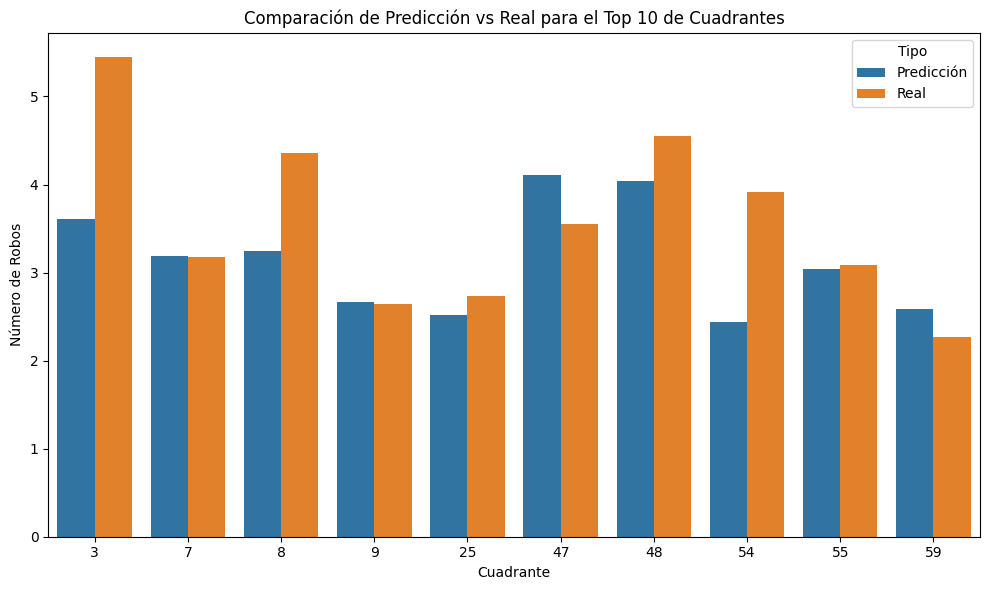

In [10]:
# graficar predicción vs real por cuadrante
import matplotlib.pyplot as plt
import seaborn as sns
# Preparar datos para graficar
df_grafico = top_10_prediccion_enero.melt(id_vars=['CUADRANTE'], 
                                    value_vars=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'], 
                                    var_name='Tipo', value_name='Robos')
# Asegurar orden consistente de categorías (opcional pero útil)
df_grafico['Tipo'] = pd.Categorical(df_grafico['Tipo'], categories=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'])
# Crear la gráfica con paleta explícita y conservar handles para la leyenda
plt.figure(figsize=(10, 6))
palette = ['#1f77b4', '#ff7f0e']  # azul y naranja (puedes cambiar los hex)
ax = sns.barplot(data=df_grafico, x='CUADRANTE', y='Robos', hue='Tipo', palette=palette)
ax.set_title('Comparación de Predicción vs Real para el Top 10 de Cuadrantes')
ax.set_xlabel('Cuadrante')
ax.set_ylabel('Número de Robos')
# Obtener handles y labels generados por seaborn y reemplazar las etiquetas por español
handles, labels = ax.get_legend_handles_labels()
ax.legend(title='Tipo', handles=handles, labels=['Predicción', 'Real'])
plt.tight_layout()
plt.show()

# Predicción para el mes de febrero

In [13]:
## ----------------------------------------------------------------------
# USO Y RESULTADO
# ----------------------------------------------------------------------

# --- SIMULACIÓN DE DATOS REALES DE UN MES (Mes 14 = Febrero) ---
# En un escenario real, df_datos_reales serían 78 filas con los robos reales de Febrero.
# Para la simulación, usaremos los robos promedio de Febrero (MES 2) de tu histórico como si fueran los "reales". Esto se puede cambiar para poder predecir cualquier otro mes, del 13 al 24.
df_febrero_real = df_final[df_final['MES_N'] == 2][['CUADRANTE', 'ROBOS_MES_N']].copy()
df_febrero_real.rename(columns={'ROBOS_MES_N': 'ROBOS_MES_N_REAL'}, inplace=True)

top_10_prediccion_febrero, r2_final_febrero, mae_final_febrero = predecir_y_evaluar_top_cuadrantes(
    mes_a_predecir=14, # El mes que estamos prediciendo
    df_historico=df_final,
    modelo=model_scaled,
    escalador=scaler,
    df_datos_reales=df_febrero_real.rename(columns={'ROBOS_MES_N_REAL': 'ROBOS_MES_N'}) # Se debe llamar ROBOS_MES_N
)

print("\n### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###")
print(f"R² del Mes Predicho vs. Mes Real: {r2_final_febrero:.4f}")
print(f"Error Absoluto Medio (MAE): {mae_final_febrero:.4f} (Robos de diferencia promedio)")
print("\nTOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:")
print(top_10_prediccion_febrero)

--- Ejecutando Predicción y Evaluación para el Mes 14 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###
R² del Mes Predicho vs. Mes Real: 0.8464
Error Absoluto Medio (MAE): 0.3370 (Robos de diferencia promedio)

TOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:
    CUADRANTE  PREDICCION_ROBOS_MES_N  MES_PREDICHO  ROBOS_REALES_MES_N
46         47                    4.36            14                5.91
47         48                    4.21            14                4.27
2           3                    3.63            14                4.18
6           7                    3.31            14                4.55
7           8                    3.22            14                3.36
54         55                    3.04            14                2.27
8           9                    2.75            14                3.91
58         59                    2.52            14                2.55
24         25                    2.50            1

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


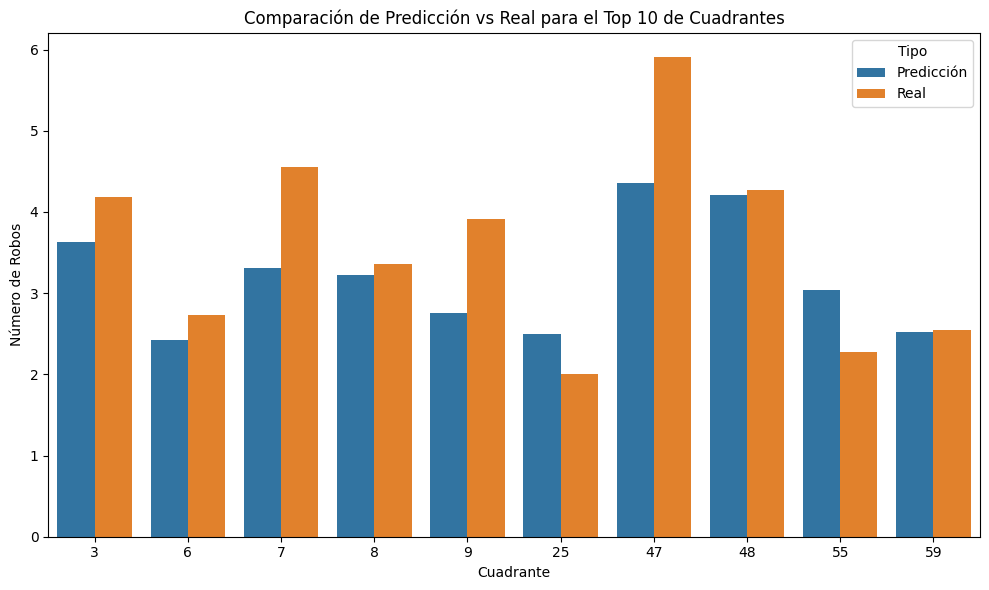

In [12]:
# graficar predicción vs real por cuadrante
import matplotlib.pyplot as plt
import seaborn as sns
# Preparar datos para graficar
df_grafico = top_10_prediccion_febrero.melt(id_vars=['CUADRANTE'], 
                                    value_vars=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'], 
                                    var_name='Tipo', value_name='Robos')
# Asegurar orden consistente de categorías (opcional pero útil)
df_grafico['Tipo'] = pd.Categorical(df_grafico['Tipo'], categories=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'])
# Crear la gráfica con paleta explícita y conservar handles para la leyenda
plt.figure(figsize=(10, 6))
palette = ['#1f77b4', '#ff7f0e']  # azul y naranja (puedes cambiar los hex)
ax = sns.barplot(data=df_grafico, x='CUADRANTE', y='Robos', hue='Tipo', palette=palette)
ax.set_title('Comparación de Predicción vs Real para el Top 10 de Cuadrantes')
ax.set_xlabel('Cuadrante')
ax.set_ylabel('Número de Robos')
# Obtener handles y labels generados por seaborn y reemplazar las etiquetas por español
handles, labels = ax.get_legend_handles_labels()
ax.legend(title='Tipo', handles=handles, labels=['Predicción', 'Real'])
plt.tight_layout()
plt.show()